In [1]:
%matplotlib inline

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import theano 
from theano import tensor as T
from theano.tensor.nnet import conv
from theano.tensor.nnet import softmax
from theano.tensor import shared_randomstreams
from theano.tensor.signal import downsample
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

print(theano.config.device) # We're using CPUs (for now)
print(theano.config.floatX) # Should be 64 bit for CPUs

np.random.seed(0)

Using gpu device 0: GRID K520 (CNMeM is disabled, CuDNN not available)
/usr/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


gpu
float32


In [2]:
#### Constants
GPU = True
if GPU:
    print("Trying to run under a GPU.  If this is not desired, then set the GPU flag to False.")
    try: theano.config.device = 'gpu'
    except: pass # it's already set
    theano.config.floatX = 'float32'
else:
    print ("Running with a CPU.  If this is not desired, then set the GPU flag to True.")


Trying to run under a GPU.  If this is not desired, then set the GPU flag to False.


In [4]:
# If on Laptop
training_file_name = 'C:\\Megan\\Education\\Berkeley\\W207\\HW\\FinalProject-NN\\training.csv'
test_file_name = 'C:\Megan\Education\Berkeley\W207\HW\FinalProject-NN\w207-Final-Project\data\test.csv'


In [4]:
# If on AWS
training_file_name = '//data//w207-Final-Project//data//training.csv'
test_file_name = '//data//w207-Final-Project//data//test.csv'

In [5]:
#training data:  7049 rows x 31 columns
# load pandas dataframe
df_train = read_csv(training_file_name)
# drop all rows that have missing values in them
# 2284 images left in training data
df_train = df_train.dropna()
#print(df_train['Image'])
# take the pandas Series and convert each row to a np.array
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, dtype=np.float32, sep=' '))
#df_train = df_train.dropna()

#print(df_train.count())  # prints the number of values for each column

# Convert pandas Series in to np.array for size (2140, 9216)
X1 = np.vstack(df_train['Image'].values) / 255.  # scale pixel values to [0, 1]
# this was done up top when converting to the strings to np.array
print(X1.shape)

# RESHAPE TO 2D
# reshapes X to a 2140 row array of 96x96 arrays, but the 1 adds and extra array in there, I'm
# not sure why
#X = X.reshape(-1, 1, 96, 96)
#print(X)
#print(X.shape)

Y1 = df_train[df_train.columns[:-1]].values
# scale target coordinates to [-1, 1]
Y1 = (Y1 - 48) / 48 
Y1 = Y1.astype(np.float32)
print(Y1.shape)

# shuffle train data
X1, Y1 = shuffle(X1, Y1, random_state=14)

#shared_X = theano.shared(np.asarray(data[0], dtype=theano.config.floatX), borrow=True)
#shared_y = theano.shared(np.asarray(data[1], dtype=theano.config.floatX), borrow=True)
#shared_X = theano.shared(X.astype(theano.config.floatX), borrow=True)
#shared_y = theano.shared(y.astype(theano.config.floatX), borrow=True)
# the types should be set properly already, so don't need to do the above
shared_X = theano.shared(X1, borrow=True)
shared_Y = theano.shared(Y1, borrow=True)
#print(shared_X)
#print(shared_Y)
#print(shared_Y.get_value)

num_dev_examples = 340
num_train_examples = X1.shape[0]-num_dev_examples
train_data, train_labels = X1[:num_train_examples], Y1[:num_train_examples]
dev_data, dev_labels = X1[num_train_examples:], Y1[num_train_examples:]
print(train_data.shape)
print(dev_data.shape)


(2140, 9216)
(2140, 30)
(1800, 9216)
(340, 9216)


In [7]:
def RMSE (y, y_pred):
    return 48*sqrt(mean_squared_error(y, y_pred))

def RMSE_tensor (y, y_pred):
    return 48*T.pow(T.mean(T.pow(T.sub(y, y_pred),2)),0.5)

def MSE (y, y_pred):
    return mean_squared_error(y, y_pred)

def MSE_tensor (y, y_pred):
    return T.mean(T.pow(T.sub(y, y_pred),2))

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

def plot_samples(num_samples, X_images, Y_pred):
    #X, _ = load(test=True)
    #y_pred = net1.predict(X)
    #X_image = dev_data
    #Y_pred = predict(dev_data)

    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_samples):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(X_images[i], Y_pred[i], ax)

    plt.show()

Train time = 0.00
RMSE = 3.1949
Prediction time = 0.00


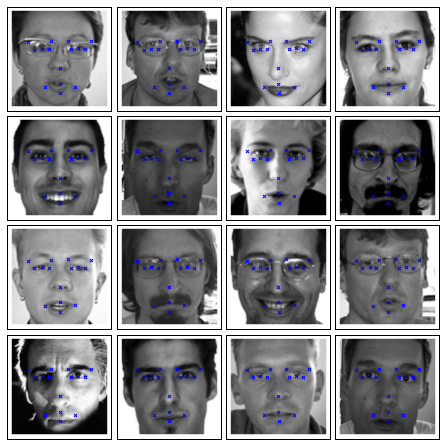

In [8]:
start_time = time.time()
mean_labels = np.asarray(np.mean(train_labels, axis=0))
predict =[]
for i in range(dev_labels.shape[0]):
    predict.append(mean_labels)
predict = np.asarray(predict)
print('Train time = %.2f' %(time.time() - start_time))
start_time = time.time()
RMSE_score = RMSE(dev_labels, predict)
print('RMSE = %.4f' %(RMSE_score))
print('Prediction time = %.2f' %(time.time() - start_time))
#print(predict)
#print()
#print(dev_labels)
plot_samples(16, dev_data, predict)

Train time = 102.37
Accuracy = 0.3251
RMSE = 2.6167
Prediction time = 0.21


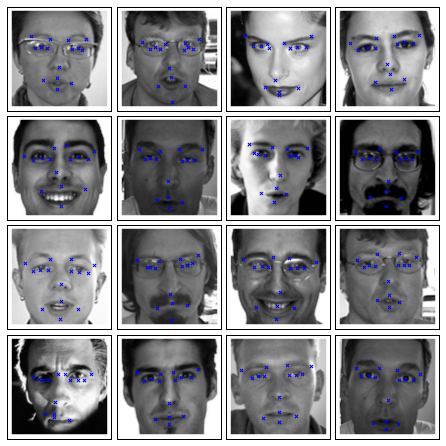

In [10]:
lm = LinearRegression()
start_time = time.time()
lm.fit(train_data, train_labels)
print('Train time = %.2f' %(time.time() - start_time))
start_time = time.time()
accuracy = lm.score(dev_data, dev_labels)
RMSE_score = RMSE(dev_labels, lm.predict(dev_data))
print('Accuracy = %.4f' %(accuracy))
print('RMSE = %.4f' %(RMSE_score))
print('Prediction time = %.2f' %(time.time() - start_time))
#print(lm.predict(dev_data))
#print()
#print(dev_labels)
plot_samples(16, dev_data, lm.predict(dev_data))

In [229]:
# Make a 1-layer fully-connected layer
numFeatures = train_data.shape[1]
numClasses = train_labels.shape[1]

## (1) Parameters 
# Initialize the weights to small, but non-zero, values.
w = theano.shared(np.asarray((np.random.randn(*(numFeatures, numClasses))*.01)))

## (2) Model
# Theano objects accessed with standard Python variables
X = T.matrix()
Y = T.matrix()

def model(X, w):
    #return T.nnet.softmax(T.dot(X, w))
    return T.dot(X, w)
y_hat = model(X, w)

## (3) Cost function
#cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))
cost = RMSE_tensor(Y, y_hat)

## (4) Objective (and solver)

alpha = 0.01
gradient = T.grad(cost=cost, wrt=w) 
update = [[w, w - gradient * alpha]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) # computes cost, then runs update
#y_pred = T.argmax(y_hat, axis=1) # select largest probability as prediction
y_pred = y_hat
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

In [230]:

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    for i in range(epochs):
        start_time = time.time()
        cost = train(train_data[0:len(train_data)], train_labels[0:len(train_data)])
        trainTime =  trainTime + (time.time() - start_time)
        #print('%d) accuracy = %.4f' %(i+1, np.mean(dev_labels == predict(dev_data))))
        print('%d) RMSE = %.4f' %(i+1, RMSE(dev_labels, predict(dev_data))))
    print('train time = %.2f' %(trainTime))

gradientDescent(50)

start_time = time.time()
print(predict(dev_data))
print()
print(dev_labels)
print('predict time = %.2f' %(time.time() - start_time))


1) RMSE = 1629.4311
2) RMSE = 111.9540
3) RMSE = 1625.0181
4) RMSE = 116.3331
5) RMSE = 1621.2407
6) RMSE = 120.0908
7) RMSE = 1617.8530
8) RMSE = 123.4646
9) RMSE = 1614.7504
10) RMSE = 126.5560
11) RMSE = 1611.8751
12) RMSE = 129.4219
13) RMSE = 1609.1890
14) RMSE = 132.0998
15) RMSE = 1606.6642
16) RMSE = 134.6176
17) RMSE = 1604.2790
18) RMSE = 136.9963
19) RMSE = 1602.0164
20) RMSE = 139.2532
21) RMSE = 1599.8623
22) RMSE = 141.4021
23) RMSE = 1597.8052
24) RMSE = 143.4545
25) RMSE = 1595.8353
26) RMSE = 145.4200
27) RMSE = 1593.9443
28) RMSE = 147.3070
29) RMSE = 1592.1252
30) RMSE = 149.1224
31) RMSE = 1590.3718
32) RMSE = 150.8723
33) RMSE = 1588.6787
34) RMSE = 152.5622
35) RMSE = 1587.0414
36) RMSE = 154.1965
37) RMSE = 1585.4557
38) RMSE = 155.7794
39) RMSE = 1583.9178
40) RMSE = 157.3145
41) RMSE = 1582.4246
42) RMSE = 158.8052
43) RMSE = 1580.9732
44) RMSE = 160.2543
45) RMSE = 1579.5608
46) RMSE = 161.6644
47) RMSE = 1578.1851
48) RMSE = 163.0379
49) RMSE = 1576.8441
50) 

In [231]:
miniBatchSize = 10 
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
            cost = train(train_data[start:end], train_labels[start:end])
        trainTime =  trainTime + (time.time() - start_time)
        #print('%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test_labels_b, axis=1) == predict(test_data))))
        print('%d) RMSE = %.4f' %(i+1, RMSE(dev_labels, predict(dev_data))))
    print('train time = %.2f' %(trainTime))
    
gradientDescentStochastic(50)

start_time = time.time()
print(predict(dev_data))
print()
print(dev_labels)   
print('predict time = %.2f' %(time.time() - start_time))

1) RMSE = 777.6316
2) RMSE = 805.5973
3) RMSE = 784.2250
4) RMSE = 785.4413
5) RMSE = 803.5226
6) RMSE = 795.2780
7) RMSE = 783.1715
8) RMSE = 792.1795
9) RMSE = 811.9529
10) RMSE = 792.7695
11) RMSE = 798.3496
12) RMSE = 791.7761
13) RMSE = 780.6899
14) RMSE = 795.5855
15) RMSE = 792.7733
16) RMSE = 784.7700
17) RMSE = 788.4301
18) RMSE = 781.7236
19) RMSE = 790.5533
20) RMSE = 791.1899
21) RMSE = 777.6666
22) RMSE = 787.1878
23) RMSE = 789.1413
24) RMSE = 783.4525
25) RMSE = 785.6683
26) RMSE = 784.1949
27) RMSE = 787.6235
28) RMSE = 785.3474
29) RMSE = 781.9634
30) RMSE = 787.8653
31) RMSE = 785.6211
32) RMSE = 783.7202
33) RMSE = 785.4902
34) RMSE = 784.6199
35) RMSE = 786.2055
36) RMSE = 784.5847
37) RMSE = 783.7304
38) RMSE = 786.0983
39) RMSE = 784.7170
40) RMSE = 784.7085
41) RMSE = 785.3618
42) RMSE = 784.3909
43) RMSE = 785.1133
44) RMSE = 785.3363
45) RMSE = 784.8289
46) RMSE = 784.4812
47) RMSE = 784.9282
48) RMSE = 785.7353
49) RMSE = 784.3437
50) RMSE = 784.3098
train tim

1) RMSE = 5.7156, T_MSE = 0.0134, D_MSE = 0.0142, T_MSE/D_MSE = 0.9449
2) RMSE = 5.4088, T_MSE = 0.0119, D_MSE = 0.0127, T_MSE/D_MSE = 0.9410
3) RMSE = 5.1745, T_MSE = 0.0109, D_MSE = 0.0116, T_MSE/D_MSE = 0.9409
4) RMSE = 4.9593, T_MSE = 0.0101, D_MSE = 0.0107, T_MSE/D_MSE = 0.9417
5) RMSE = 4.7509, T_MSE = 0.0092, D_MSE = 0.0098, T_MSE/D_MSE = 0.9393
6) RMSE = 4.5806, T_MSE = 0.0085, D_MSE = 0.0091, T_MSE/D_MSE = 0.9317
7) RMSE = 4.4366, T_MSE = 0.0079, D_MSE = 0.0085, T_MSE/D_MSE = 0.9269
8) RMSE = 4.3190, T_MSE = 0.0074, D_MSE = 0.0081, T_MSE/D_MSE = 0.9144
9) RMSE = 4.2168, T_MSE = 0.0070, D_MSE = 0.0077, T_MSE/D_MSE = 0.9058
10) RMSE = 4.1198, T_MSE = 0.0066, D_MSE = 0.0074, T_MSE/D_MSE = 0.8976
11) RMSE = 4.0740, T_MSE = 0.0064, D_MSE = 0.0072, T_MSE/D_MSE = 0.8870
12) RMSE = 3.9979, T_MSE = 0.0061, D_MSE = 0.0069, T_MSE/D_MSE = 0.8783
13) RMSE = 3.9259, T_MSE = 0.0058, D_MSE = 0.0067, T_MSE/D_MSE = 0.8696
14) RMSE = 3.8656, T_MSE = 0.0056, D_MSE = 0.0065, T_MSE/D_MSE = 0.8595
1

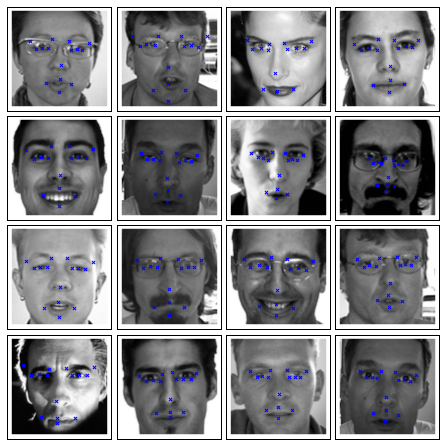

[[ 0.35925892 -0.22073757 -0.37660993 ...,  0.41747331 -0.00818548
   0.69118031]
 [ 0.46712647 -0.31347498 -0.48492158 ...,  0.51678947 -0.01825465
   0.87525708]
 [ 0.37926053 -0.24791279 -0.37575295 ...,  0.67181926 -0.04031105
   0.69694193]
 ..., 
 [ 0.25364553 -0.17008371 -0.24972874 ...,  0.23593277  0.01020066
   0.48292526]
 [ 0.37523614 -0.24732666 -0.39551528 ...,  0.44935267 -0.01191952
   0.75255046]
 [ 0.35384161 -0.18548847 -0.33588203 ...,  0.4347011  -0.03257842
   0.68343494]]

[[ 0.37493804 -0.22492035 -0.37649557 ...,  0.3920531  -0.04428319
   0.70844245]
 [ 0.36380953 -0.31905952 -0.35442856 ...,  0.37429762  0.02330952
   0.65455955]
 [ 0.40427768 -0.25025392 -0.34064388 ...,  0.64121503  0.02158226
   0.67658919]
 ..., 
 [ 0.42576978 -0.25333524 -0.3587338  ...,  0.33182734  0.05280576
   0.73050362]
 [ 0.32419595 -0.23639189 -0.42129055 ...,  0.58404052 -0.02291216
   0.74576354]
 [ 0.39980751 -0.08407042 -0.1373709  ...,  0.48282158  0.10331456
   0.58696711]]

In [8]:
numFeatures = train_data.shape[1]
numClasses = train_labels.shape[1]

## (1) Parameters
numHiddenNodes = 100 
w_1 = theano.shared(np.asarray((np.random.randn(*(numFeatures, numHiddenNodes))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2]


## (2) Model
X = T.matrix()
Y = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model(X, w_1, w_2):
    #return T.nnet.softmax(T.dot(T.nnet.sigmoid(T.dot(X, w_1)), w_2))
    # use sigmoint for hidden layer activation
    #return T.dot(T.nnet.sigmoid(T.dot(X, w_1)), w_2)
    # use rectifier for hidden layer activation
    return T.dot(T.maximum(0., T.dot(X, w_1)), w_2)
y_hat = model(X, w_1, w_2)

## (3) Cost...same as logistic regression
#cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))
cost = MSE_tensor(Y, y_hat)

## (4) Minimization.  Update rule changes to backpropagation.
alpha = 0.01
#alpha = 0.005
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha])
    return updates
update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
#y_pred = T.argmax(y_hat, axis=1)
y_pred = y_hat
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
            cost = train(train_data[start:end], train_labels[start:end])
        trainTime =  trainTime + (time.time() - start_time)
        #print('%d) accuracy = %.4f' %(i+1, np.mean(np.argmax(test_labels_b, axis=1) == predict(test_data))))
        D_RMSE = RMSE(dev_labels, predict(dev_data))
        T_MSE = MSE(train_labels, predict(train_data))
        D_MSE = MSE(dev_labels, predict(dev_data))
        print('%d) RMSE = %.4f, T_MSE = %.4f, D_MSE = %.4f, T_MSE/D_MSE = %.4f' % (i+1, D_RMSE, T_MSE, D_MSE, T_MSE/D_MSE))
    print('train time = %.2f' %(trainTime))

gradientDescentStochastic(15)

start_time = time.time()
plot_samples(16, dev_data, predict(dev_data))
print(predict(dev_data))
print()
print(dev_labels)  
print('predict time = %.2f' %(time.time() - start_time))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.


1) RMSE = 9.5486, T_MSE = 0.0384, D_MSE = 0.0396, T_MSE/D_MSE = 0.9699
train time = 65.03


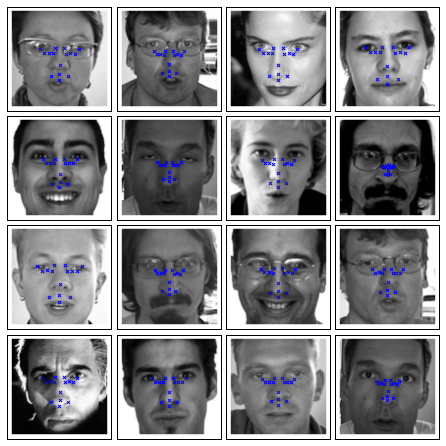

[[ 0.22396398 -0.13428368 -0.23116572 ...,  0.30790006 -0.00832572
   0.44486881]
 [ 0.17822459 -0.10693109 -0.18392986 ...,  0.24478642 -0.00656753
   0.35388901]
 [ 0.22200252 -0.13337795 -0.22911511 ...,  0.30547391 -0.00805114
   0.44064416]
 ..., 
 [ 0.09537647 -0.05738619 -0.09855201 ...,  0.13115995 -0.00359101
   0.18944814]
 [ 0.2081305  -0.12452904 -0.21493226 ...,  0.28645329 -0.00781476
   0.41418571]
 [ 0.20330151 -0.12189618 -0.20996126 ...,  0.27933345 -0.00780434
   0.40420799]]
()
[[ 0.37493804 -0.22492035 -0.37649557 ...,  0.3920531  -0.04428319
   0.70844245]
 [ 0.36380953 -0.31905952 -0.35442856 ...,  0.37429762  0.02330952
   0.65455955]
 [ 0.40427768 -0.25025392 -0.34064388 ...,  0.64121503  0.02158226
   0.67658919]
 ..., 
 [ 0.42576978 -0.25333524 -0.3587338  ...,  0.33182734  0.05280576
   0.73050362]
 [ 0.32419595 -0.23639189 -0.42129055 ...,  0.58404052 -0.02291216
   0.74576354]
 [ 0.39980751 -0.08407042 -0.1373709  ...,  0.48282158  0.10331456
   0.58696711

In [14]:
# Adding convolutional layers

theano.config.floatX = 'float64'

numFeatures = train_data.shape[1]
numClasses = train_labels.shape[1]

## (1) Parameters
numHiddenNodes = 100 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 16
featureMapsLayer2 = 16
featureMapsLayer3 = 16

# For convonets, we will work in 2d rather than 1d.  The images are 96x96 in 2d.
imageWidth = 96
train_data_2d = train_data.reshape(-1, 1, imageWidth, imageWidth)
#test_data_2d = test_data.reshape(-1, 1, imageWidth, imageWidth)
dev_data_2d = dev_data.reshape(-1, 1, imageWidth, imageWidth)

# Convolution layers.  
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))
w_2 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01)))
w_3 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01)))

# Fully connected NN. 
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer3 * 11 * 11, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]

## (2) Model
#X = T.matrix()
X = T.tensor4(dtype=theano.config.floatX) # conv2d works with tensor4 type
Y = T.matrix()

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X

# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid

# Theano provides built-in support for add convolutional layers
def model(X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
    l1 = dropout(max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2), ignore_border=True), p_1)
    l2 = dropout(max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2), ignore_border=True), p_1)
    l3 = dropout(T.flatten(max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2)), outdim=2), p_1) # flatten to switch back to 1d layers
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_2)
    return T.dot(l4, w_5)

#y_hat = model(X, w_1, w_2)
y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)
#y_x = y_hat

## (3) Cost
#cost = T.mean(T.nnet.categorical_crossentropy(y_hat, Y))
#cost = T.mean(T.nnet.categorical_crossentropy(y_hat_train, Y))
cost = MSE_tensor(Y, y_hat_train)

## (4) Minimization.  Update rule changes to backpropagation.
def backprop(cost, w, alpha=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
#y_pred = T.argmax(y_hat_predict, axis=1)
y_pred = y_hat_predict
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

miniBatchSize = 1
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_data_2d), miniBatchSize), range(miniBatchSize, len(train_data_2d), miniBatchSize)):
            cost = train(train_data_2d[start:end], train_labels[start:end])
        trainTime =  trainTime + (time.time() - start_time)
        D_RMSE = RMSE(dev_labels, predict(dev_data_2d))
        T_MSE = MSE(train_labels, predict(train_data_2d))
        D_MSE = MSE(dev_labels, predict(dev_data_2d))
        print('%d) RMSE = %.4f, T_MSE = %.4f, D_MSE = %.4f, T_MSE/D_MSE = %.4f' % (i+1, D_RMSE, T_MSE, D_MSE, T_MSE/D_MSE))
    print('train time = %.2f' %(trainTime))

gradientDescentStochastic(1)

start_time = time.time()
plot_samples(16, dev_data_2d, predict(dev_data_2d))
# predict(test_data) ??am I doing test_data or dev_data here
print(predict(dev_data_2d))
print()
print(dev_labels)  
print('predict time = %.2f' %(time.time() - start_time))